In [43]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
expers_to_load = [# Meta V1 model regressionT
                  (True, "run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05"), # 50ops
                  (False, "run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05"), # 100ops
                  (True, "run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05"), # stochastic 26 ops
                  # Stick-breaking V1 model
                  (False, "run_20170724_22_55_12_actV2_70ep_32ops_lr5e05_adam"), # nu=0.1
                  (False, "run_20170811_15_54_49_act_sbV1_45ep_nu0.2_lr5e05"), # nu=0.2
                  (False, "run_20170815_17_15_28_act_sbV1_50ep_nu0.3_lr5e05"), # nu=0.3
                  (False, "run_20170724_17_46_16_actV2_70ep_32ops_lr5e05_adam"), # nu=0.6
                  (False, "run_20170814_14_27_22_act_sbV1_50ep_nu0.7_lr5e05"), # nu=0.7
                  (False, "run_20170815_16_02_52_act_sbV1_50ep_nu0.8_lr5e05"), # nu=0.8
                  (False, "run_20170815_16_29_43_act_sbV2_50ep_nu0.8_lr5e05"), # nu=0.8 with 20epos annealing until 0.5
                  (False, "run_20170814_12_41_13_act_sbV1_50ep_nu0.9_lr5e05"), # 0.9
                  (False, "run_20170815_09_44_40_act_sbV2_50ep_nu0.9_lr5e05"), # 0.9 with 40steps annealing
                  (False, "run_20170816_10_21_59_act_sbV1_50ep_nu0.95_lr5e05"), # nu=0.95 
                  (False, "run_20170816_09_29_29_act_sbV2_50ep_nu0.95_lr5e05"), # nu=0.95 20 step annealing 0.5
                  (True, "run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05"), # nu=0.95 40 step annealing 1.0
                  (False, "run_20170814_18_16_12_act_sbV1_50ep_nu0.99_lr5e05"), # 0.99 with annealing
                  # Stick-breaking V3 model with neg-binomial
                  (False, "run_20170815_10_22_49_act_sbV3_50ep_nu0.5_lr5e05"), # nu=0.5 n=50
                  # ACT-SB V4 with act + meta loss
                  (False, "run_20170815_14_07_20_act_sbV4_50ep_nu0.9_lr5e05")] # nu=0.9


In [75]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        exp = Experiment.load(exp_path[1], do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config))
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger


INFO - created local logger for experiment with model metaV1_regression_T_50ops
INFO - INFO - loaded existing model from file logs/run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05/metaV1_regression_T_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model metaV2_regression_T_26ops
INFO - INFO - loaded existing model from file logs/run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05/metaV2_regression_T_26ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_o

0 Loading model metaV1_regression_T_50ops / run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05
1 Loading model metaV2_regression_T_26ops / run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05
2 Loading model act_sbV2_regression_T_nu0.95 (q-prob 0.95) / run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05


In [76]:
del new_experiments
new_experiments = []
max_eval_steps = 500

for exper in expers_to_load:
    if exper[0]:
        print("Loading experiment {}".format(exper[1]))
        new_experiments.append(Experiment.load(path_to_exp=exper[1] + "/" + 
                                               "exp_eval_stats_10000_" + str(max_eval_steps) +"steps.dll",
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05
Loading experiment run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05
Loading experiment run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05
Ready


In [62]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/10regT_actsb_compare_metaV1V2_actsb95_anneal_0_50.png


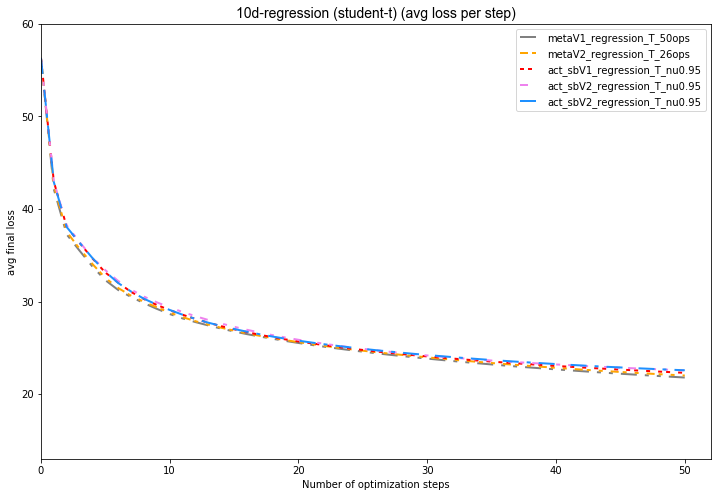

In [12]:
# new_exp_select = [new_experiments[3], new_experiments[4], new_experiments[7]] #, new_experiments[4]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10regT_actsb_compare_metaV1V2_actsb95_anneal_0_50", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=50,
                                              sort_exper="10d-regression (student-t)",
                                              log_scale=False,
                                              with_stddev=False,
                                              runID=None)

INFO - Successfully saved fig logs/run_20170814_19_02_30_act_sbV1_50ep_nu0.9_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.9_08:58:01.png


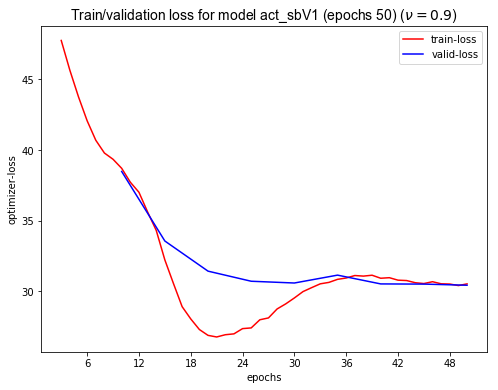

In [5]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [70]:
exp_idx = 4
model = models[exp_idx]

max_steps = 500
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"

epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_sbV1_regression_T_nu0.8 with q-prob 0.800


INFO - ! - Validation last step 33 - !
INFO - Epoch: 400 - showing only last 100 time steps
INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 18.383  18.381  18.378  18.375  18.372  18.366  18.362  18.361  18.358
  18.352  18.352  18.35   18.34   18.343  18.338  18.336  18.331  18.324
  18.326  18.323  18.315  18.316  18.311  18.308  18.308  18.3    18.301
  18.295  18.291  18.291  18.284  18.284  18.278  18.275  18.274  18.274
  18.265  18.265  18.261  18.26   18.255  18.252  18.247  18.246  18.243
  18.238  18.238  18.236  18.226  18.23   18.221  18.222  18.222  18.212
  18.216  18.209  18.209  18.204  18.202  18.202  18.196  18.195  18.189
  18.189  18.185  18.182  18.179  18.177  18.172  18.172  18.166  18.162
  18.159  18.156  18.153  18.154  18.148  18.147  18.143  18.141  18.141
  18.133  18.132  18.129  18.127  18.124  18.119  18.118  18.115  18.107
  18.108  18.11   18.102  18.102  18.098  18.097  18.098  18.082  18.089
  18.085  18.08 ]
INFO - Epoch: 400 - End

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [23]:

exp_idx = 0
max_steps = 500
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_T_50ops with 10000 functions


Validating model metaV1_regression_T_50ops with q-prob 0.950


INFO - INFO - Epoch 400, elapsed time 20.22 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 9.272e+03/16.21/4.766
INFO - >>> NOTE: only showing last 100 steps <<<
INFO - INFO - Epoch 400: Final step losses: [ 16.543  16.54   16.536  16.533  16.528  16.524  16.52   16.516  16.512
  16.508  16.503  16.501  16.497  16.493  16.489  16.486  16.481  16.478
  16.475  16.47   16.467  16.463  16.46   16.457  16.453  16.449  16.445
  16.442  16.439  16.434  16.431  16.427  16.424  16.42   16.416  16.412
  16.408  16.405  16.401  16.397  16.394  16.391  16.388  16.384  16.381
  16.378  16.374  16.37   16.368  16.363  16.359  16.356  16.354  16.349
  16.347  16.344  16.34   16.336  16.334  16.331  16.327  16.325  16.321
  16.319  16.316  16.312  16.309  16.305  16.303  16.299  16.296  16.294
  16.291  16.288  16.285  16.282  16.279  16.276  16.273  16.271  16.267
  16.265  16.263  16.26   16.257  16.254  16.252  16.248  16.245  16.24

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


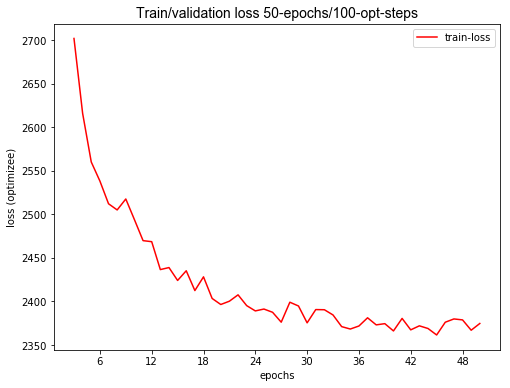

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [ ]:
plot_actsb_qts(new_experiments[3], data_set="eval", save=False, show=True, add_info=False, epoch=400, 
              fig_name="qt_dist_test_eval_500steps")

INFO - Successfully saved fig logs/run_20170815_14_33_06_act_sbV2_50ep_nu0.95_lr5e05/T_dist_eval.png


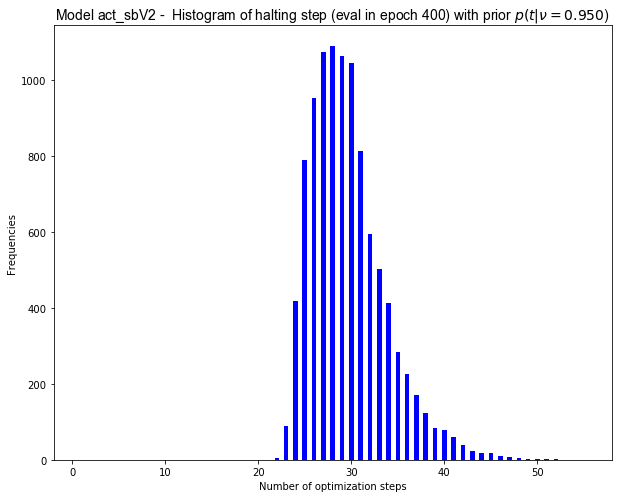

In [79]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400)

INFO - Successfully saved fig logs/run_20170815_16_02_52_act_sbV1_50ep_nu0.8_lr5e05/halting_step_versus_nll_distance.png


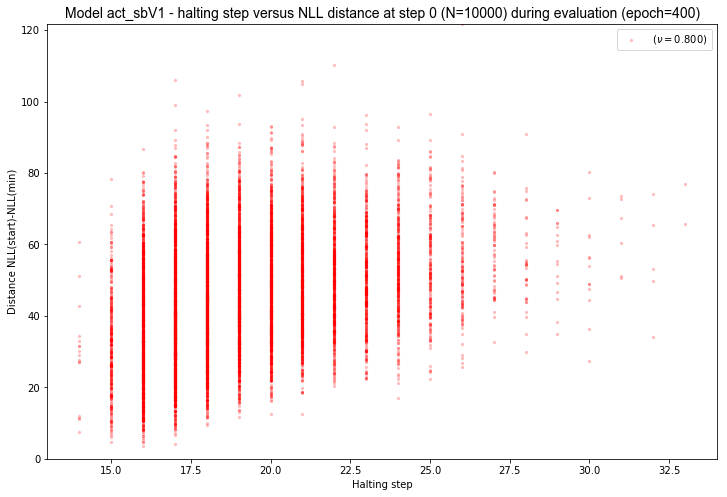

In [73]:
plot_loss_versus_halting_step(new_experiments[4], epoch=400, do_show=True, do_save=True)

In [47]:
new_experiments[3].val_stats["halt_step_funcs"][400]

array([ 41.,  51.,  36., ...,  51.,  58.,  45.], dtype=float32)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


In [ ]:
plot_qt_detailed_stats(new_experiments[0], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [11]:
experiments[3].generate_figures()

INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/loss_act_sbV1_50ep_nu0.95_17:31:24.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/loss_optimizer_act_sbV1_50ep_nu0.95_17:31:24.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_loss_map_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/eval_step_loss_map_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_map_qts_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/train_step_map_halting_act_sbV1_50ep_nu0.95.png
INFO - Successfully saved fig logs/run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05/qt_values_train_act_sbV1_50ep_nu0.